# 0822_Study
- trial 1: XGBoost 모델을 LGBM로 돌려보자
## LightGBM
- LightGBM의 메인 기술은 GOSS(Gradient-based One-Side Sampling)입니다. GOSS는 Information gain을 계산할 때 기울기가 작은(가중치가 작은)개체에 승수 상수를 적용하여 데이터를 증폭시킵니다. 이렇게 함으로써 데이터 분포를 많이 변경하지 안혹도 훈련이 덜 된 개체에 초점을 보다 잘 맞출 수 있습니다.
- 이러한 방법은 LightGBM이 XGBoost보다 속도와 성능면에서 모두 좋은 퍼포먼스를 가질 수 있게 했습니다. (특히 속도)
    
    <p align = "center"><img src="https://blog.kakaocdn.net/dn/dsAyLL/btqXJWNRzgF/V0fFXLv9TXGJedlG20RIJK/img.png" width="500" height="200"/></p>
    <p align = "center"><img src="https://blog.kakaocdn.net/dn/carb0s/btqXD29c4fG/pvFhJRHDUhdcGY0kU1fal1/img.png" width="500" height="200"/></p>
    
- 일반 GBM 계열의 트리는 level-wise(균형 트리 분할) 방식을 채택합니다. 그림을 보시면 알겠지만 항상 균형을 이루며 2진 분할을 하고 있습니다.
- 반면 LightGBM에서 채택한 leaf-wise(리프 중심 트리 분할)은 트리가 깊어지면서 소요되는 시간과 메모리 모두를 절약 할 수 있었습니다.
- LightGBM은 위와 같은 방법을 통해서 굉장히 가벼운 알고리즘이면서도 좋은 성능을 낼 수 있었는데요, 단점은 없을까요?
- 공식문서에서는 적은 데이터에 대한 Overfitting이 일어나기 쉽다고 말하고있습니다. 여기서 '적다'의 기준은 약 10000건 으로 보고있습니다.


## 1. Libraries

In [23]:
import os
import re
import nltk
import string
import warnings
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb #modified
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings('ignore')

In [2]:
class config:
    sample_submission_path = '/kaggle/input/commonlit-evaluate-student-summaries/sample_submission.csv'
    prompts_train_path = '/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv'
    summaries_test_path = '/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv'
    summaries_train_path = '/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv'
    prompts_test_path = '/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv'

## 2. Loading Data
- 총 데이터 파일 수: 5개
- input으로 사용할 파일: 4개
    - prompts_train 
    - summaries_test 
    - summaries_train 
    - prompts_test
- prompts_* 를 summary한 것이 summarise_*
- prompts_test를 summarize하여 summarise_test에 넣고, 그에 따른 content와 wording에 대한 결과를 submission file에 넣으면 됨

In [3]:
sample_submission = pd.read_csv(config.sample_submission_path)
prompts_train = pd.read_csv(config.prompts_train_path)
summaries_test = pd.read_csv(config.summaries_test_path)
summaries_train = pd.read_csv(config.summaries_train_path)
prompts_test = pd.read_csv(config.prompts_test_path)

print(f'sample_submission shape: {sample_submission.shape}')
print(f'prompts_train shape: {prompts_train.shape}')
print(f'summaries_test shape: {summaries_test.shape}')
print(f'summaries_train shape: {summaries_train.shape}')
print(f'prompts_test shape: {prompts_test.shape}')
print('-'*90)
print(f'sample_submission missing values: {sample_submission.isnull().sum().sum()}')
print(f'prompts_train missing values: {prompts_train.isnull().sum().sum()}')
print(f'summaries_test missing values: {summaries_test.isnull().sum().sum()}')
print(f'summaries_train missing values: {summaries_train.isnull().sum().sum()}')
print(f'prompts_test missing values: {prompts_test.isnull().sum().sum()}')
print('-'*90)
summaries_train.head()

sample_submission shape: (4, 3)
prompts_train shape: (4, 4)
summaries_test shape: (4, 3)
summaries_train shape: (7165, 5)
prompts_test shape: (2, 4)
------------------------------------------------------------------------------------------
sample_submission missing values: 0
prompts_train missing values: 0
summaries_test missing values: 0
summaries_train missing values: 0
prompts_test missing values: 0
------------------------------------------------------------------------------------------


,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


In [4]:
prompts_train.head()

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


In [5]:
prompts_test.head()

,prompt_id,prompt_question,prompt_title,prompt_text
0,abc123,Summarize...,Example Title 1,Heading\nText...
1,def789,Summarize...,Example Title 2,Heading\nText...


In [6]:
summaries_test.head()

,student_id,prompt_id,text
0,000000ffffff,abc123,Example text 1
1,111111eeeeee,def789,Example text 2
2,222222cccccc,abc123,Example text 3
3,333333dddddd,def789,Example text 4


In [7]:
sample_submission

,student_id,content,wording
0,000000ffffff,0.0,0.0
1,111111eeeeee,0.0,0.0
2,222222cccccc,0.0,0.0
3,333333dddddd,0.0,0.0


## 3. Target Distribution


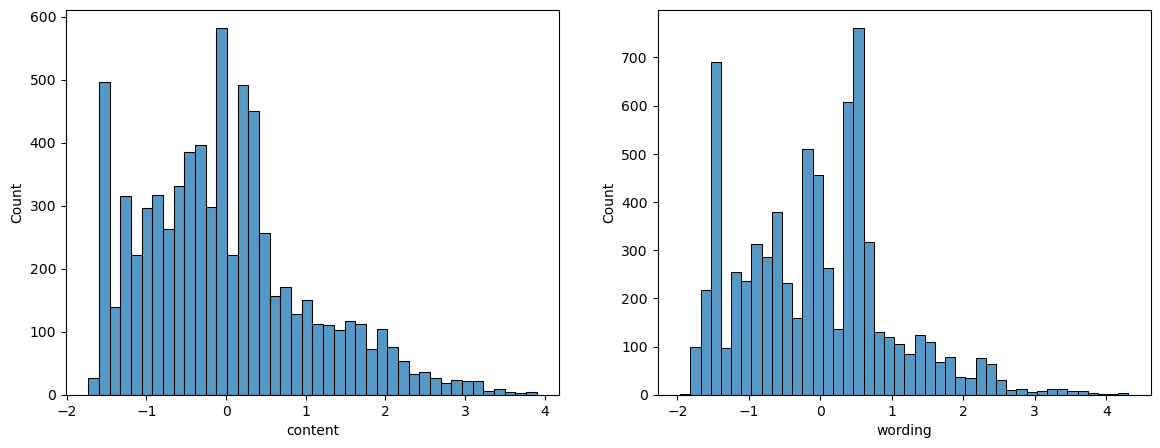

In [8]:
plt.figure(figsize = (14, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=summaries_train, x='content')
plt.subplot(1, 2, 2)
sns.histplot(data=summaries_train, x='wording')
plt.show()

## 4. Feature Engineering

In [9]:
def clean_text(text: str) -> str:
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

def count_total_words(text: str) -> int:
    words = text.split()
    total_words = len(words)
    return total_words

def count_stopwords(text: str) -> int:
    stopword_list = set(stopwords.words('english'))
    words = text.split()
    stopwords_count = sum(1 for word in words if word.lower() in stopword_list)
    return stopwords_count

def count_punctuation(text: str) -> int:
    punctuation_set = set(string.punctuation)
    punctuation_count = sum(1 for char in text if char in punctuation_set)
    return punctuation_count

def count_numbers(text: str) -> int:
    numbers = re.findall(r'\d+', text)
    numbers_count = len(numbers)
    return numbers_count

def feature_engineer(dataframe: pd.DataFrame, feature: str = 'text') -> pd.DataFrame:
    dataframe[f'{feature}_length'] = dataframe[feature].apply(lambda x: len(x))
    dataframe[f'{feature}_word_cnt'] = dataframe[feature].apply(lambda x: count_total_words(x))
    dataframe[f'{feature}_stopword_cnt'] = dataframe[feature].apply(lambda x: count_stopwords(x))
    dataframe[f'{feature}_punct_cnt'] = dataframe[feature].apply(lambda x: count_punctuation(x))
    dataframe[f'{feature}_number_cnt'] = dataframe[feature].apply(lambda x: count_numbers(x))
    return dataframe

In [10]:
summaries_train = feature_engineer(summaries_train)
summaries_test = feature_engineer(summaries_test)

In [11]:
vectorizer = TfidfVectorizer(encoding='utf-8',
                             ngram_range=(1, 1),
                             lowercase=True,
                             stop_words=list(stopwords.words('english')),
                             max_features=250)

train_vectorized = pd.DataFrame(
                vectorizer.fit_transform(summaries_train['text']).toarray(),
                columns=[f"tfidf_{str(f)}" for f in vectorizer.get_feature_names_out()],
            )

test_vectorized = pd.DataFrame(
                vectorizer.transform(summaries_test['text']).toarray(),
                columns=[f"tfidf_{str(f)}" for f in vectorizer.get_feature_names_out()],
            )

summaries_train = pd.concat([summaries_train, train_vectorized], axis=1)

summaries_test = pd.concat([summaries_test, test_vectorized], axis=1)

summaries_train.head()

,student_id,prompt_id,text,content,wording,text_length,text_word_cnt,text_stopword_cnt,text_punct_cnt,text_number_cnt,...,tfidf_well,tfidf_whenever,tfidf_white,tfidf_whole,tfidf_work,tfidf_worked,tfidf_workers,tfidf_working,tfidf_would,tfidf_write
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,346,61,25,3,0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,244,52,30,2,0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.252892,0.0,0.425880,0.000000
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,1370,235,98,38,0,...,0.089862,0.0,0.0,0.0,0.091531,0.0,0.090915,0.0,0.306210,0.116408
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,157,25,11,6,2,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,1225,203,92,30,3,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.159293,0.000000


In [21]:
features = summaries_train.drop(columns = ['student_id', 'prompt_id', 'text', 'content', 'wording'], axis = 1).columns


0       0.205683
1      -0.548304
2       3.128928
3      -0.210614
4       3.272894
          ...   
7160    0.205683
7161   -0.308448
7162   -1.408180
7163   -0.393310
7164    1.771596
Name: content, Length: 7165, dtype: float64
0       0.380538
1       0.506755
2       4.231226
3      -0.471415
4       3.219757
          ...   
7160    0.380538
7161    0.048171
7162   -0.493603
7163    0.627128
7164    0.547742
Name: wording, Length: 7165, dtype: float64


## 5. Modeling_modified

In [55]:
summaries_test[features].head()

,text_length,text_word_cnt,text_stopword_cnt,text_punct_cnt,text_number_cnt,tfidf_able,tfidf_according,tfidf_actions,tfidf_also,tfidf_ancient,...,tfidf_well,tfidf_whenever,tfidf_white,tfidf_whole,tfidf_work,tfidf_worked,tfidf_workers,tfidf_working,tfidf_would,tfidf_write
0,14,3,0,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,14,3,0,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,14,3,0,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,14,3,0,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
N_FOLDS = 3
SEED = 42
NUM_ROUNDS = 5000
EARLY_STOPPING_ROUNDS = 500
VERBOSE = 500

params = {
    'learning_rate': 0.01,
    'max_depth':16,
    'boosting':'gbdt',
    'objective':'regression',
    'metric':'rmse',
    'is_training_metric':True,
    'num_leaves': 144,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq':5,
#     'force_row_wise': True
    'force_col_wise': True, 
    'verbose': -1
#     'seed': 2002
    
}

for target in ['content', 'wording']:
    X = summaries_train[features]
    y = summaries_train[target]
    X_test = summaries_test[features]
    y_test = np.zeros(shape=summaries_test.shape[0], dtype=float)
    
    cv = KFold(n_splits = N_FOLDS, shuffle = True, random_state = SEED)
    for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        print(f"| Target: {target} - Fold {idx+1} |".center(80, "-"))
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]
        print(f'train: {X_train.shape}')
        print(f'val: {X_val.shape}')
        train_ds = lgb.Dataset(X_train, label = y_train)
        test_ds = lgb.Dataset(X_val, label= y_val)
        
        
#         model = xgb.train(params=params,
#                           dtrain=dtrain,
#                           evals=[(dtrain, 'train'), (dval, 'validation')],
#                           num_boost_round=NUM_ROUNDS,
#                           early_stopping_rounds=EARLY_STOPPING_ROUNDS,
#                           verbose_eval=VERBOSE)
        
        model = lgb.train(params,
                          train_ds,
                          5000,
                          test_ds,
                          verbose_eval=500, 
                          early_stopping_rounds=500) 
        
        y_test = model.predict(X_test) #/ N_FOLDS # td-idf
    sample_submission[target] = y_test
print('done')

--------------------------| Target: content - Fold 1 |--------------------------
train: (4776, 255)
val: (2389, 255)
Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 0.457541
[1000]	valid_0's rmse: 0.453677
[1500]	valid_0's rmse: 0.454794
Early stopping, best iteration is:
[1160]	valid_0's rmse: 0.453572
--------------------------| Target: content - Fold 2 |--------------------------
train: (4777, 255)
val: (2388, 255)
Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 0.46465
[1000]	valid_0's rmse: 0.460055
Early stopping, best iteration is:
[924]	valid_0's rmse: 0.459833
--------------------------| Target: content - Fold 3 |--------------------------
train: (4777, 255)
val: (2388, 255)
Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 0.470892
[1000]	valid_0's rmse: 0.468029
Early stopping, best iteration is:
[910]	valid_0's rmse: 0.467768
--------------------------| Target: wording 

In [58]:
y_test

array([-1.47058453, -1.47058453, -1.47058453, -1.47058453])

In [59]:
sample_submission

,student_id,content,wording
0,000000ffffff,-1.523098,-1.470585
1,111111eeeeee,-1.523098,-1.470585
2,222222cccccc,-1.523098,-1.470585
3,333333dddddd,-1.523098,-1.470585


In [60]:
sample_submission.to_csv('submission.csv', index=False)